In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gmsh
import os
import meshio


In [2]:
# Inicializar Gmsh
gmsh.initialize()

# Abrir archivo .geo
file = "llave.geo"
gmsh.open(file)  # <-- Esta es la clave para cargar la geometría

# Añadir nombre del modelo (opcional si ya está en el archivo)
gmsh.model.setCurrent("llave")

# Sincronizar por si quieres modificar algo en Python
gmsh.model.geo.synchronize()

# Lanzar la interfaz gráfica para visualizar
#gmsh.fltk.run()

# Finalizar Gmsh cuando termines
gmsh.finalize()


Info    : Reading 'llave.geo'...
Info    : Done reading 'llave.geo'


In [3]:
#Establezco el tamaño de la malla
lc = 10

# Inicializar Gmsh
gmsh.initialize()

# Cargar archivo .geo
gmsh.open(file)

# Establecer parámetros de mallado
gmsh.option.setNumber("Mesh.CharacteristicLengthMin", lc)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax", lc)

# Sincronizar (por si hay geometría a modificar, aunque ya fue cargada)
gmsh.model.geo.synchronize()

# Generar la malla (2 = malla 2D, 3 = malla 3D)
gmsh.model.mesh.generate(3)

# Exportar la malla a archivo .msh si lo deseas
output_file = 'malla.msh'
gmsh.write(output_file)

# Visualizar
#gmsh.fltk.run()

gmsh.finalize()

Info    : Reading 'llave.geo'...
Info    : Done reading 'llave.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 101 (Circle)
Info    : [ 10%] Meshing curve 102 (Line)
Info    : [ 10%] Meshing curve 103 (Circle)
Info    : [ 20%] Meshing curve 104 (Line)
Info    : [ 20%] Meshing curve 201 (Circle)
Info    : [ 30%] Meshing curve 202 (Circle)
Info    : [ 30%] Meshing curve 203 (Line)
Info    : [ 30%] Meshing curve 204 (Line)
Info    : [ 40%] Meshing curve 205 (Circle)
Info    : [ 40%] Meshing curve 206 (Circle)
Info    : [ 50%] Meshing curve 207 (Circle)
Info    : [ 50%] Meshing curve 208 (Circle)
Info    : [ 60%] Meshing curve 301 (Line)
Info    : [ 60%] Meshing curve 302 (Line)
Info    : [ 60%] Meshing curve 303 (Circle)
Info    : [ 70%] Meshing curve 304 (Circle)
Info    : [ 70%] Meshing curve 305 (Circle)
Info    : [ 80%] Meshing curve 306 (Line)
Info    : [ 80%] Meshing curve 307 (Line)
Info    : [ 80%] Meshing curve 401 (Line)
Info    : [ 90%] Meshing curve 402 (Line)
Info

In [4]:
import meshio

# Cargar el archivo de malla .msh (versión 4.1 de Gmsh)
mesh = meshio.read(output_file)

for i, (cell_block, phys_ids) in enumerate(zip(mesh.cells, mesh.cell_data["gmsh:physical"])):
    print(f"Block {i} - Tipo: {cell_block.type}, Cantidad: {len(cell_block.data)}, Physical tags: {set(phys_ids)}")



Block 0 - Tipo: triangle, Cantidad: 32, Physical tags: {1}
Block 1 - Tipo: triangle, Cantidad: 77, Physical tags: {2}
Block 2 - Tipo: triangle, Cantidad: 27, Physical tags: {3}
Block 3 - Tipo: triangle, Cantidad: 24, Physical tags: {4}


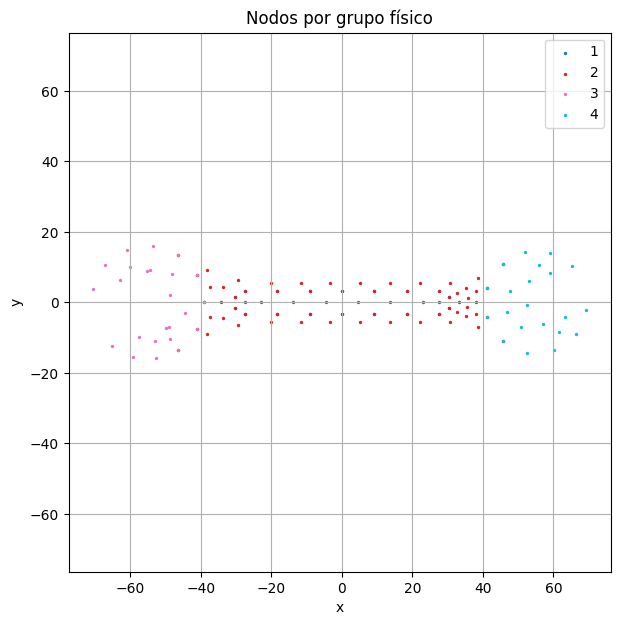

In [12]:
import meshio
from nodes import Node
mesh = meshio.read(output_file)

# Asociación de tag físico con nombre
tag_to_name = {v[0]: k for k, v in mesh.field_data.items()}

# Construimos el diccionario {nombre_grupo: [Node, Node, ...]}
grupos = {}

for cell_block, phys_tags in zip(mesh.cells, mesh.cell_data["gmsh:physical"]):
    if cell_block.type != "triangle":
        continue
    for tri, tag in zip(cell_block.data, phys_tags):
        nombre = tag_to_name.get(tag, f"{tag}")
        if nombre not in grupos:
            grupos[nombre] = []

        for node_id in tri:
            x, y = mesh.points[node_id][:2]
            grupos[nombre].append(Node(node_id, x, y))

# Eliminar nodos duplicados en cada grupo
for nombre in grupos:
    nodos_unicos = {}
    for n in grupos[nombre]:
        nodos_unicos[n.id] = n
    grupos[nombre] = list(nodos_unicos.values())

# Ploteo por grupo
Node.plot_nodes_por_grupo(grupos, show_ids=False)


In [13]:
from section import Section

#Ahora creo las 4 secciones posibles
thicknes = {"1": 2.0, "2": 4.0, "3": 5.0, "4": 5.0}
sections = {}

#Defino las propiedades del material

E = 210000
nu = 0.3
rho = 7850

for group in thicknes:
    sections[group] = Section(thicknes[group], E, nu)


In [26]:
for group in grupos:
    for node in (grupos[group]):
        print(node.id)

3
73
75
1
74
76
0
2
24
35
31
28
33
26
79
80
77
78
25
34
32
27
22
23
29
30
83
89
87
88
82
22
37
38
23
56
95
84
92
55
0
3
9
93
85
86
90
8
54
53
30
81
29
51
36
52
50
39
2
1
91
94
4
44
31
45
28
5
25
49
24
26
48
47
27
46
43
32
42
33
34
41
35
40
6
7
10
11
12
6
98
13
50
100
57
96
61
64
97
15
58
63
14
51
59
60
99
62
52
7
17
16
19
69
10
18
72
71
101
102
70
20
65
68
66
21
105
103
55
104
56
11
67


In [27]:
nodes_dict = {}
for group in grupos:
    for node in grupos[group]:
        nodes_dict[node.id] = node


In [ ]:
from cst import CST

triangles = mesh.cells_dict['triangle']  # nodos por cada triángulo
tags = mesh.cell_data_dict["gmsh:physical"]["triangle"]
elements = []

for i in range(len(tags)):
    section = sections[str(tags[i])]

    node_ids = triangles[i]
    nodo_a = nodes_dict[node_ids[0]]
    nodo_b = nodes_dict[node_ids[1]]
    nodo_c = nodes_dict[node_ids[2]]

    elements.append(CST(i+1, [nodo_a, nodo_b, nodo_c], section))



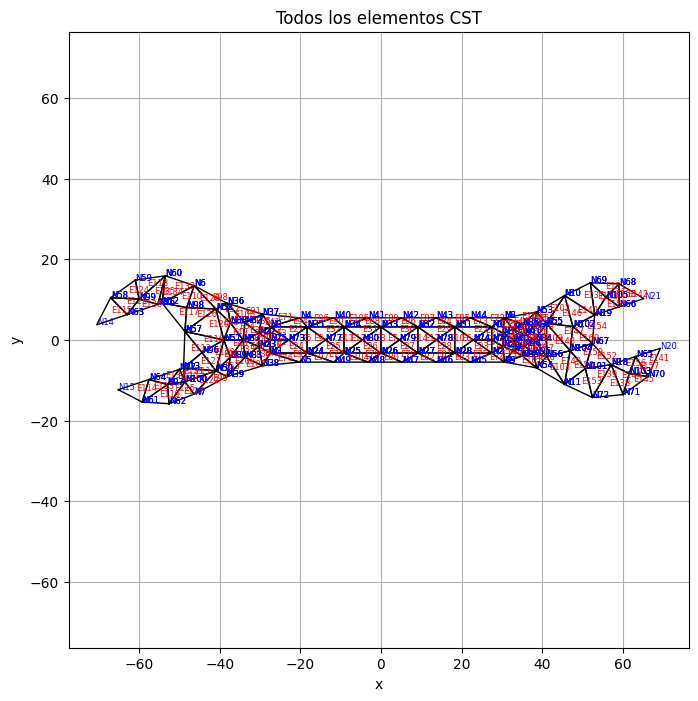

In [32]:
import matplotlib.pyplot as plt

def plot_all_elements(elements, show_ids=True):
    """
    Dibuja todos los elementos CST en una sola figura.

    Parámetros:
    - elements: lista de instancias de CST
    - show_ids: si True, muestra los ID de los nodos y elementos
    """
    plt.figure(figsize=(8, 8))
    
    for elem in elements:
        coords = elem.get_xy_matrix()
        coords = np.vstack([coords, coords[0]])  # cerrar triángulo

        # Dibujar contorno del triángulo
        plt.plot(coords[:, 0], coords[:, 1], 'k-', linewidth=1)

        # Dibujar centroides y nodos
        if show_ids:
            for node in elem.node_list:
                plt.text(node.x, node.y, f'N{node.id}', color='blue', fontsize=6)
            centroid = elem.get_centroid()
            plt.text(centroid[0], centroid[1], f'E{elem.element_tag}', color='red', fontsize=6)

    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis('equal')
    plt.grid(True)
    plt.title("Todos los elementos CST")
    plt.show()


plot_all_elements(elements, show_ids=True)